In [3]:
import torch as th
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from pprint import pprint
from Algorithms.ddpg import config

# 0. Plot Setting

In [4]:
import seaborn as sb
import matplotlib

sb.set_style('whitegrid')

FONTSIZE = 10
matplotlib.rcParams["figure.figsize"] = (10, 5)
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["figure.titlesize"] = FONTSIZE
matplotlib.rcParams["legend.fontsize"] = FONTSIZE
matplotlib.rcParams["xtick.labelsize"] = FONTSIZE
matplotlib.rcParams["ytick.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.titlesize"] = FONTSIZE
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.6

# P&L Training

## 1. Load Config

In [3]:
env_kwargs, model_kwargs, learn_kwargs = config.load_config('tmp_config.yaml')
# env_kwargs, model_kwargs, learn_kwargs = config.load_config('../logs/tb_logs/ddpg_220616-2239_1_ddpg_pnl/config.yaml')

env 'BSMarket was created!
env 'BSMarket was created!


In [1]:
ntb_mode = True
double_ddpg = True

env_kwargs.update({
    'drift': 1.0,
    'reward_fn': 'mean var',
    'reward_fn_kwargs': {},
    'reward_mode': 'pnl'
})

model_kwargs.update({
    'buffer_size': 300,
    'learning_starts': 300,
    'batch_size': 15,
    'mean_coeff': 1.5,
    'std_coeff': 0.02 if ntb_mode else 0.01
})

model_kwargs['policy_kwargs'].update({
    'ntb_mode': ntb_mode,
    'double_ddpg': double_ddpg,
})

learn_kwargs.update({
    'total_timesteps': 2000
})

# del model_kwargs['std_coeff']

if ntb_mode:
    actor_net_kwargs = {'bn_kwargs': {'num_features': env_kwargs['n_assets']}}
    critic_net_kwargs = {'bn_kwargs': {'num_features': env_kwargs['n_assets']}}

    model_kwargs['policy_kwargs'].update({
        'net_arch': {'pi': [(nn.BatchNorm1d, 'bn'), 32, 32],
                     'qf': [(nn.BatchNorm1d, 'bn'), 16],
                     'qf2': [(nn.BatchNorm1d, 'bn'), 4]},
        'actor_net_kwargs': actor_net_kwargs,
        'critic_net_kwargs': critic_net_kwargs,
    })

    model_kwargs['policy_kwargs']['features_extractor_kwargs'].update({
        'features_out': 64,
        'net_arch': [32]
    })

else:
    model_kwargs['policy_kwargs'].update({
        'net_arch': [],
    })

    model_kwargs['policy_kwargs']['features_extractor_kwargs'].update({
        'features_out': 2,
        'net_arch': [32, 64]
    })

model_kwargs['policy_kwargs']['one_asset'] = (env_kwargs['n_assets']==1)

NameError: name 'env_kwargs' is not defined

In [ ]:
config.reconstruct_config(env_kwargs, model_kwargs, learn_kwargs)

In [ ]:
pprint(env_kwargs)

In [ ]:
pprint(model_kwargs)

In [ ]:
pprint(learn_kwargs)

## 2. Make env, model

In [ ]:
from Algorithms.ddpg import DoubleDDPG
# from Algorithms.ddpg.double_ddpg import DDPG

# model = DoubleDDPG(**model_kwargs)
model = DoubleDDPG(**model_kwargs)

In [ ]:
model.policy

## 3. Learning

In [11]:
model = model.learn(**learn_kwargs)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ../logs/tb_logs\ddpg_220618-1142_1
[Training Start]
Eval num_timesteps=30, episode_reward=-0.03 +/- 0.00
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30       |
|    mean_reward     | -0.0327  |
| time/              |          |
|    total timesteps | 30       |
---------------------------------
New best mean reward!
Eval num_timesteps=60, episode_reward=-0.03 +/- 0.00
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30       |
|    mean_reward     | -0.0328  |
| time/              |          |
|    total timesteps | 60       |
---------------------------------
Eval num_timesteps=90, episode_reward=-0.03 +/- 0.00
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30       |
|    mea

In [120]:
config.save_config(f'{learn_kwargs["eval_log_path"]}/config.yaml', env_kwargs, model_kwargs, learn_kwargs)

<BSMarket instance> will be save as name. env_kwargs not in kwargs!
<BSMarketEval instance> will be save as name. eval_env_kwargs not in kwargs!
<Algorithms.ddpg.callbacks.ReportCallbacks object at 0x000002354BAF86A0> will be save as name. callback_kwargs not in kwargs!
../logs/tb_logs/ddpg_220618-1043_1/config.yaml was saved.


## 4. P&L Evaluation

In [12]:
# model = model.load('../logs/tb_logs/ddpg_220617-1922_1'+'/best_model')
model = model.load(learn_kwargs['eval_log_path'] + '/best_model')
print(learn_kwargs['eval_log_path'] + '/best_model')

../logs/tb_logs/ddpg_220618-1142_1/best_model


In [13]:
eval_env = learn_kwargs['eval_env']
eval_env.reward_mode = 'pnl'

In [35]:
class Tmp:
    def predict(self, obs, deterministic=False):
        return np.zeros(1000), None

tmp = Tmp()
zero_pnl = eval_env.eval(tmp, 'pnl', 100)
random_pnl = eval_env.eval(None, 'pnl', 100)

In [15]:
# zero_pnl = np.load('best_results/zero_pnl.npy')
# random_pnl = np.load('best_results/random_pnl.npy')

rl_pnl = np.load('best_results/pnl_train/rl_pnl_drift.npy')
# rl_cash = np.load('best_results/pnl_train/rl_cash.npy')

# ntb_pnl = np.load('best_results/pnl_train/ntb_pnl.npy')
# ntb_cash = np.load('best_results/pnl_train/ntb_cash.npy')

In [16]:
# rl_pnl = eval_env.eval(model, 'pnl', 100)
# ntb_pnl = eval_env.eval(model, 'pnl', 100)

ntb_pnl = eval_env.eval(model, 'pnl', 100)
# ntb_cash = eval_env.eval(model, 'cash', 100)

# delta_pnl = eval_env.delta_eval('pnl', 100)
# delta_cash = eval_env.delta_eval('cash', 100)

In [77]:
# np.save('best_results/zero_pnl', zero_pnl)
# np.save('best_results/zero_cash', zero_cash)

# np.save('best_results/pnl_train/rl_pnl', ntb_pnl)
# np.save('best_results/pnl_train/rl_cash', ntb_cash)

# np.save('best_results/pnl_train/ntb_pnl', ntb_pnl)
# np.save('best_results/pnl_train/ntb_cash', ntb_cash)

In [17]:
def pnl_reward(pnl):
    mean = np.mean(pnl)
    std = np.std(pnl)
    return [mean - 0.02 * std , mean, std]

def sharpe_ratio(pnl):
    return pnl.mean()/pnl.std()

def var(pnl, ratio):
    losses = np.sort(-pnl)
    boundary = int(np.ceil(losses.shape[-1]*ratio))
    return losses[boundary]

def cvar(pnl, ratio=0.95):
    losses = np.sort(-pnl)
    boundary = int(np.ceil(losses.shape[-1]*ratio))
    return np.mean(losses[boundary:], axis=-1)

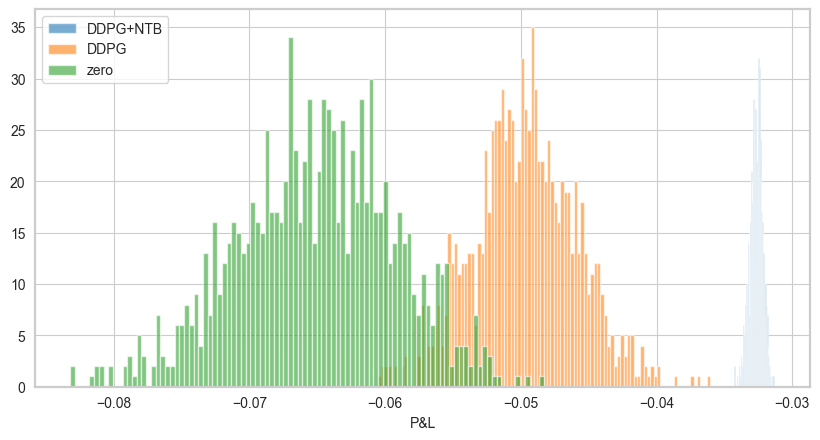

ntb pnl: 		[-0.0327 -0.0327  0.0005]
rl pnl: 		[-0.0498 -0.0497  0.0038]
zero pnl: 		[-0.0652 -0.0651  0.0059]
random pnl: 	[-0.2445 -0.2444  0.0047]

ntb cvar:		0.03371
rl cvar:		0.05763
zero cvar:		0.07759
random cvar:	0.25417



In [23]:
plt_kwargs = {'bins': 100,
              # 'range': (-0.06, -0.03),
              'alpha': 0.6}

plt.xlabel('P&L')
plt.hist(ntb_pnl,**plt_kwargs, label='DDPG+NTB')
plt.hist(rl_pnl, **plt_kwargs, label='DDPG')
plt.hist(zero_pnl,**plt_kwargs, label='zero')
# plt.hist(random_pnl,**plt_kwargs, label='random')
# plt.hist(delta_pnl,**plt_kwargs, label='delta')
plt.legend()
plt.show()

print(f'ntb pnl: \t\t{np.round(pnl_reward(ntb_pnl), 4)}')
print(f'rl pnl: \t\t{np.round(pnl_reward(rl_pnl), 4)}')
print(f'zero pnl: \t\t{np.round(pnl_reward(zero_pnl), 4)}')
print(f'random pnl: \t{np.round(pnl_reward(random_pnl), 4)}')
# print(f'delta pnl: \t\t{np.round(pnl_reward(delta_pnl), 4)}')
print()

print(f'ntb cvar:\t\t{cvar(ntb_pnl):.5f}')
print(f'rl cvar:\t\t{cvar(rl_pnl):.5f}')
print(f'zero cvar:\t\t{cvar(zero_pnl):.5f}')
print(f'random cvar:\t{cvar(random_pnl):.5f}')
# print(f'delta cvar:\t\t{cvar(delta_pnl):.5f}')
print()

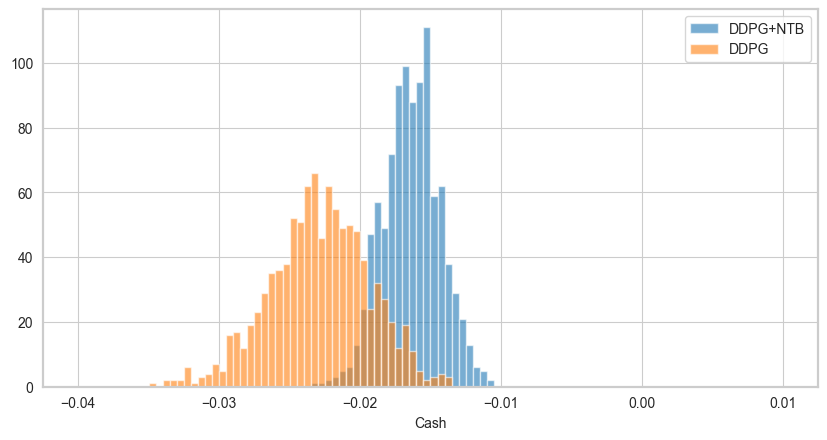

ntb cash: 		[-0.0164 -0.0164  0.002 ]
rl cash: 		[-0.023  -0.0229  0.0035]

ntb cvar:		0.02048
rl cvar:		0.03066



In [30]:
plt_kwargs = {'bins': 100,
              'range': (-0.04, 0.01),
              'alpha': 0.6}

plt.xlabel('Cash')
plt.hist(ntb_cash,**plt_kwargs, label='DDPG+NTB')
plt.hist(rl_cash, **plt_kwargs, label='DDPG')
# plt.hist(zero_cash,**plt_kwargs, label='zero')
# plt.hist(random_cash,**plt_kwargs, label='random')
# plt.hist(delta_cash,**plt_kwargs, label='delta')
plt.legend()
plt.show()

print(f'ntb cash: \t\t{np.round(pnl_reward(ntb_cash), 4)}')
print(f'rl cash: \t\t{np.round(pnl_reward(rl_cash), 4)}')
# print(f'zero cash: \t\t{np.round(pnl_reward(zero_cash), 4)}')
# print(f'random cash: \t{np.round(pnl_reward(random_cash), 4)}')
# print(f'delta cash: \t{np.round(pnl_reward(delta_cash), 4)}')
print()

print(f'ntb cvar:\t\t{cvar(ntb_cash):.5f}')
print(f'rl cvar:\t\t{cvar(rl_cash):.5f}')
# print(f'zero cvar:\t\t{cvar(zero_cash):.5f}')
# print(f'random cvar:\t{cvar(random_cash):.5f}')
# print(f'delta cvar:\t\t{cvar(delta_cash):.5f}')
print()

In [16]:
def delta_eval2(env, reward_mode='cash', n=1):
    tmp = env.reward_mode
    env.reward_mode = reward_mode

    result = []
    for _ in range(n):
        obs = env.reset()
        reward, done, info = 0, False, {}
        total_raw_reward = 0
        i = 0
        while not done:
            action = env.delta[i+1].copy()
            obs, reward, done, info = env.step(action)
            total_raw_reward += info['raw_reward']
            i += 1
        result.append(total_raw_reward)

    env.reward_mode = tmp

    return np.mean(result, axis=0)

delta2_pnl = delta_eval2(eval_env, 'pnl', 100)
delta2_cash = delta_eval2(eval_env, 'cash', 100)

In [20]:
# np.save('best_results/pnl_train/ntb_pnl_drift', ntb_pnl)
# np.save('best_results/pnl_train/ntb_cash', ntb_cash)

In [130]:
# np.save('best_results/pnl_train/rl_pnl_drift', rl_pnl)

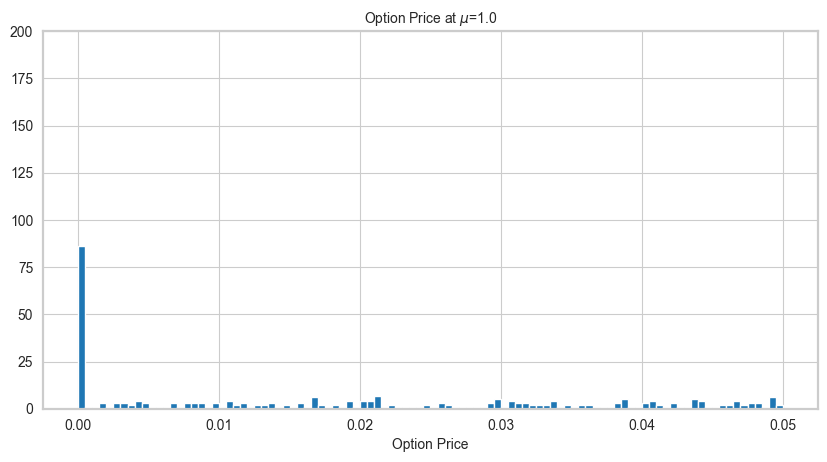

In [47]:
eval_env.drift= 1.0
plt.title(r'Option Price at $\mu$=1.0')
_ = eval_env.reset()
plt.hist(eval_env.option_prices[-1], bins=100, range=(0.0, 0.05))
plt.ylim(0, 200)
plt.xlabel('Option Price')
plt.show()

# Cash Training

## 1. Load Config

In [3]:
env_kwargs, model_kwargs, learn_kwargs = config.load_config('tmp_config.yaml')

env 'BSMarket was created!
env 'BSMarket was created!


In [4]:
ntb_mode = False
double_ddpg = True

env_kwargs.update({
    'reward_fn': 'mean var',
    'reward_fn_kwargs': {},
    'reward_mode': 'cash'
})

model_kwargs.update({
    'buffer_size': 300,
    'learning_starts': 300,
    'batch_size': 15,
    'mean_coeff': 1.0,
    'std_coeff': 1.2
})

model_kwargs['policy_kwargs'].update({
    'ntb_mode': ntb_mode,
    'double_ddpg': double_ddpg,
})

learn_kwargs.update({
    'total_timesteps': 2500
})

# del model_kwargs['std_coeff']

if ntb_mode:
    actor_net_kwargs = {'bn_kwargs': {'num_features': env_kwargs['n_assets']}}
    critic_net_kwargs = {'bn_kwargs': {'num_features': env_kwargs['n_assets']}}

    model_kwargs['policy_kwargs'].update({
        'net_arch': {'pi': [(nn.BatchNorm1d, 'bn'), 32, 32],
                     'qf': [(nn.BatchNorm1d, 'bn'), 16],
                     'qf2': [(nn.BatchNorm1d, 'bn'), 2]},
        'actor_net_kwargs': actor_net_kwargs,
        'critic_net_kwargs': critic_net_kwargs,
    })

    model_kwargs['policy_kwargs']['features_extractor_kwargs'].update({
        'features_out': 64,
        'net_arch': [32]
    })

else:
    actor_net_kwargs = {'bn_kwargs': {'num_features': env_kwargs['n_assets']}}
    critic_net_kwargs = {'bn_kwargs': {'num_features': env_kwargs['n_assets']}}

    model_kwargs['policy_kwargs'].update({
        'net_arch': {'pi': [32,],
                     'qf': [2,],
                     'qf2': [2,]},
        'actor_net_kwargs': actor_net_kwargs,
        'critic_net_kwargs': critic_net_kwargs,
    })

    model_kwargs['policy_kwargs']['features_extractor_kwargs'].update({
        'features_out': 64,
        'net_arch': [32, 64]
    })
    # model_kwargs['policy_kwargs'].update({
    #     'net_arch': [],
    # })
    #
    # model_kwargs['policy_kwargs']['features_extractor_kwargs'].update({
    #     'features_out': 2,
    #     'net_arch': [32, 32]
    # })

model_kwargs['policy_kwargs']['one_asset'] = (env_kwargs['n_assets']==1)

In [5]:
config.reconstruct_config(env_kwargs, model_kwargs, learn_kwargs)

env 'BSMarket was created!
model_kwargs['env']: <BSMarket instance>
env 'BSMarket was created!
learn_kwargs['eval_env']: <BSMarketEval instance>
learn_kwargs['tb_log_name']: ddpg_220617-1619
learn_kwargs['eval_log_path']: ../logs/tb_logs/ddpg_220617-1619_1


In [6]:
pprint(env_kwargs)

{'cost': 0.02,
 'dividend': 0.0,
 'drift': 0.0,
 'freq': 1,
 'gen_name': 'gbm',
 'init_price': 1.0,
 'maturity': 30,
 'n_assets': 1000,
 'payoff': 'european',
 'payoff_coeff': 1.0,
 'period_unit': 365,
 'reward_fn': 'mean var',
 'reward_fn_kwargs': {},
 'reward_mode': 'cash',
 'risk_free_interest': 0.0,
 'strike': 1.0,
 'volatility': 0.2}


In [7]:
pprint(model_kwargs)

{'action_noise': NormalActionNoise(mu=0.0, sigma=0.1),
 'batch_size': 15,
 'buffer_size': 300,
 'create_eval_env': False,
 'device': 'auto',
 'env': <Env.env.BSMarket object at 0x0000022ADC1A0610>,
 'gamma': 0.99,
 'gradient_steps': -1,
 'learning_rate': <function lr_schedule at 0x0000022ADC18E820>,
 'learning_starts': 300,
 'mean_coeff': 1.0,
 'optimize_memory_usage': False,
 'policy': <class 'Algorithms.ddpg.policies.DoubleDDPGPolicy'>,
 'policy_kwargs': {'activation_fn': <class 'torch.nn.modules.activation.ReLU'>,
                   'actor_net_kwargs': {'bn_kwargs': {'num_features': 1000}},
                   'critic_net_kwargs': {'bn_kwargs': {'num_features': 1000}},
                   'double_ddpg': True,
                   'features_extractor_class': <class 'Env.feature_extractor.MarketObsExtractor'>,
                   'features_extractor_kwargs': {'activation_fn': <class 'torch.nn.modules.activation.ReLU'>,
                                                 'features_in': 4,
    

In [8]:
pprint(learn_kwargs)

{'callback': <Algorithms.ddpg.callbacks.ReportCallbacks object at 0x0000022AA581C340>,
 'eval_env': <Env.env.BSMarketEval object at 0x0000022ADC1A01F0>,
 'eval_freq': 30,
 'eval_log_path': '../logs/tb_logs/ddpg_220617-1619_1',
 'log_interval': 30,
 'n_eval_episodes': 1,
 'reset_num_timesteps': True,
 'tb_log_name': 'ddpg_220617-1619',
 'total_timesteps': 2500}


In [9]:
print(model_kwargs['env'].reward_mode)
print(learn_kwargs['eval_env'].reward_mode)

cash
cash


## 2. Make env, model

In [10]:
from Algorithms.ddpg import DoubleDDPG
# from Algorithms.ddpg.double_ddpg import DDPG

# model = DoubleDDPG(**model_kwargs)
model = DoubleDDPG(**model_kwargs)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [11]:
model.policy

DoubleDDPGPolicy(
  (actor): CustomActor(
    (features_extractor): MarketObsExtractor(
      (layers): Sequential(
        (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Linear(in_features=4, out_features=32, bias=True)
        (2): ReLU()
        (3): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Linear(in_features=32, out_features=64, bias=True)
        (5): ReLU()
        (6): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): Linear(in_features=64, out_features=64, bias=True)
        (8): ReLU()
      )
    )
    (mu): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=1, bias=True)
      (3): Tanh()
    )
    (flatten): Flatten(start_dim=-2, end_dim=-1)
  )
  (actor_target): CustomActor(
    (features_extractor): MarketObsExtractor(
      (layers): S

## 3. Learning

In [12]:
model = model.learn(**learn_kwargs)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ../logs/tb_logs\ddpg_220617-1619_1
[Training Start]
Eval num_timesteps=30, episode_reward=-0.02 +/- 0.00
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30       |
|    mean_reward     | -0.0233  |
| time/              |          |
|    total timesteps | 30       |
---------------------------------
New best mean reward!
Eval num_timesteps=60, episode_reward=-0.02 +/- 0.00
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30       |
|    mean_reward     | -0.0241  |
| time/              |          |
|    total timesteps | 60       |
---------------------------------
Eval num_timesteps=90, episode_reward=-0.02 +/- 0.00
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30       |
|    mea

KeyboardInterrupt: 

In [13]:
config.save_config(f'{learn_kwargs["eval_log_path"]}/config.yaml', env_kwargs, model_kwargs, learn_kwargs)

<BSMarket instance> will be save as name. env_kwargs not in kwargs!
<BSMarketEval instance> will be save as name. eval_env_kwargs not in kwargs!
<Algorithms.ddpg.callbacks.ReportCallbacks object at 0x000002831A9C9AF0> will be save as name. callback_kwargs not in kwargs!
../logs/tb_logs/ddpg_220617-1517_1/config.yaml was saved.


## 4. P&L Evaluation

In [43]:
model = model.load(learn_kwargs['eval_log_path'] + '/best_model')
print(learn_kwargs['eval_log_path'] + '/best_model')

../logs/tb_logs/ddpg_220617-1517_1/best_model


In [15]:
eval_env = learn_kwargs['eval_env']
eval_env.reward_mode = 'pnl'

In [16]:
import numpy as np

pnl_rl_pnl = np.load('best_results/pnl_train/rl_pnl.npy')
pnl_rl_cash = np.load('best_results/pnl_train/rl_cash.npy')

pnl_ntb_pnl = np.load('best_results/pnl_train/ntb_pnl.npy')
pnl_ntb_cash = np.load('best_results/pnl_train/ntb_cash.npy')

In [17]:
def env_eval(env, model=None, reward_mode='cash'):
    tmp = env.reward_mode
    env.reward_mode = reward_mode
    obs = env.reset()
    reward, done, info = 0, False, {}
    total_raw_reward = 0
    while not done:
        if model:
            action, _ = model.predict(obs, deterministic=False)
        else:
            action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        total_raw_reward += info['raw_reward']

    env.reward_mode = tmp
    return total_raw_reward

In [18]:
cash_rl_pnl = np.mean([env_eval(eval_env, model, 'pnl') for _ in range(100)], axis=0)
cash_rl_cash = np.mean([env_eval(eval_env, model, 'cash') for _ in range(100)], axis=0)

# cash_ntb_pnl = np.mean([env_eval(eval_env, model, 'pnl') for _ in range(100)], axis=0)
# cash_ntb_cash = np.mean([env_eval(eval_env, model, 'cash') for _ in range(100)], axis=0)

In [33]:
random_cash = np.mean([env_eval(eval_env, model, 'cash') for _ in range(100)], axis=0)

In [32]:
def pnl_reward(pnl):
    mean = np.mean(pnl)
    std = np.std(pnl)
    return [mean - 0.02 * std , mean, std]

def sharpe_ratio(pnl):
    return pnl.mean()/pnl.std()

def var(pnl, ratio):
    losses = np.sort(-pnl)
    boundary = int(np.ceil(losses.shape[-1]*ratio))
    return losses[boundary]

def cvar(pnl, ratio=0.95):
    losses = np.sort(-pnl)
    boundary = int(np.ceil(losses.shape[-1]*ratio))
    return np.mean(losses[boundary:], axis=-1)

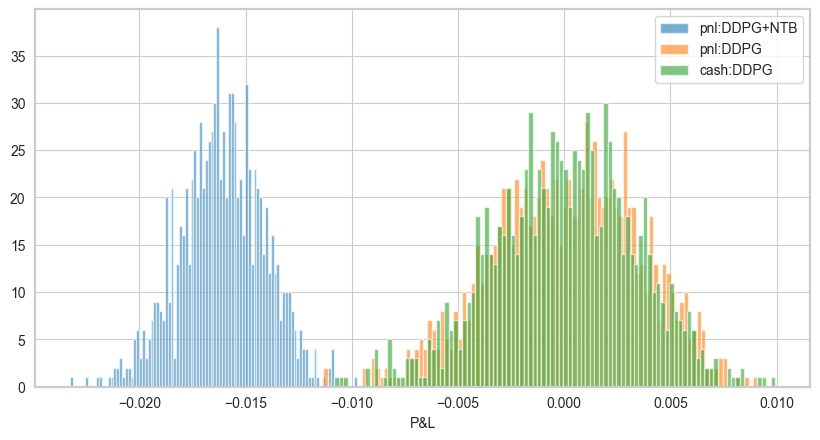

pnl:ntb pnl: 		[-0.0162 -0.0161  0.002 ]
pnl:rl pnl: 		[-0.      0.0001  0.0035]
cash:rl pnl: 		[-0.0001 -0.      0.0034]

pnl:ntb cvar:		0.02036
pnl:rl cvar:		0.00742
cash:rl cvar:		0.00731



In [30]:
plt_kwargs = {'bins': 100,
              # 'range': (-0.04, 0.01),
              'alpha': 0.6}

plt.xlabel('P&L')
plt.hist(pnl_ntb_pnl,**plt_kwargs, label='pnl:DDPG+NTB')
plt.hist(pnl_rl_pnl, **plt_kwargs, label='pnl:DDPG')
plt.hist(cash_rl_pnl, **plt_kwargs, label='cash:DDPG')
plt.legend()
plt.show()

print(f'pnl:ntb pnl: \t\t{np.round(pnl_reward(pnl_ntb_pnl), 4)}')
print(f'pnl:rl pnl: \t\t{np.round(pnl_reward(pnl_rl_pnl), 4)}')
print(f'cash:rl pnl: \t\t{np.round(pnl_reward(cash_rl_pnl), 4)}')
print()

print(f'pnl:ntb cvar:\t\t{cvar(pnl_ntb_pnl):.5f}')
print(f'pnl:rl cvar:\t\t{cvar(pnl_rl_pnl):.5f}')
print(f'cash:rl cvar:\t\t{cvar(cash_rl_pnl):.5f}')
print()

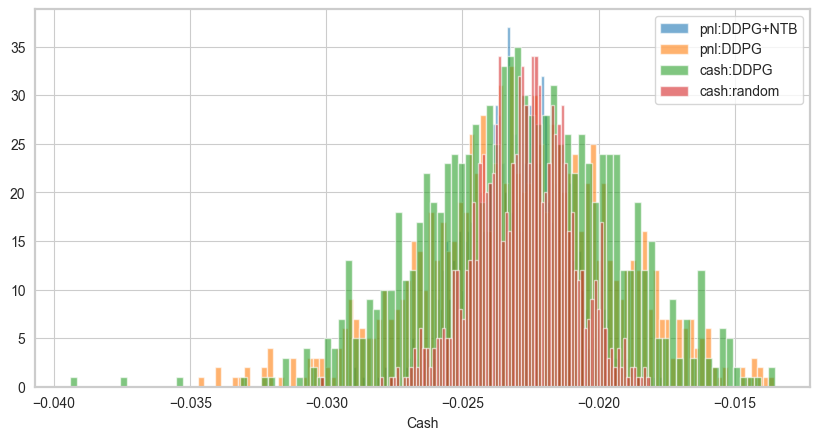

pnl:ntb cash: 		[-0.023  -0.023   0.0018]
pnl:rl cash: 		[-0.023  -0.0229  0.0035]
cash:rl cash: 		[-0.023  -0.0229  0.0035]
cash:random: 		[-0.0228 -0.0227  0.0017]

pnl:ntb cvar:		0.02667
pnl:rl cvar:		0.03066
cash:rl cvar:		0.03039
cash:random:		0.02649



In [34]:
plt_kwargs = {'bins': 100,
              # 'range': (-0.04, 0.01),
              'alpha': 0.6}

plt.xlabel('Cash')
plt.hist(pnl_ntb_cash, **plt_kwargs, label='pnl:DDPG+NTB')
plt.hist(pnl_rl_cash, **plt_kwargs, label='pnl:DDPG')
plt.hist(cash_rl_cash, **plt_kwargs, label='cash:DDPG')
plt.hist(random_cash, **plt_kwargs, label='cash:random')
plt.legend()
plt.show()

print(f'pnl:ntb cash: \t\t{np.round(pnl_reward(pnl_ntb_cash), 4)}')
print(f'pnl:rl cash: \t\t{np.round(pnl_reward(pnl_rl_cash), 4)}')
print(f'cash:rl cash: \t\t{np.round(pnl_reward(cash_rl_cash), 4)}')
print(f'cash:random: \t\t{np.round(pnl_reward(random_cash), 4)}')
print()

print(f'pnl:ntb cvar:\t\t{cvar(pnl_ntb_cash):.5f}')
print(f'pnl:rl cvar:\t\t{cvar(pnl_rl_cash):.5f}')
print(f'cash:rl cvar:\t\t{cvar(cash_rl_cash):.5f}')
print(f'cash:random:\t\t{cvar(random_cash):.5f}')
print()

In [47]:
def env_eval_action(env, model=None, reward_mode='cash'):
    tmp = env.reward_mode
    env.reward_mode = reward_mode
    obs = env.reset()
    reward, done, info = 0, False, {}
    total_raw_reward = 0
    actions = []
    for i in range(30):
        while not done:
            if model:
                action, _ = model.predict(obs, deterministic=False)
            else:
                action = env.action_space.sample()
            actions.append(action)
            obs, reward, done, info = env.step(action)

    env.reward_mode = tmp
    action_min = np.min(actions)
    action_max = np.max(actions)
    return np.mean(actions, axis=0), action_min, action_max

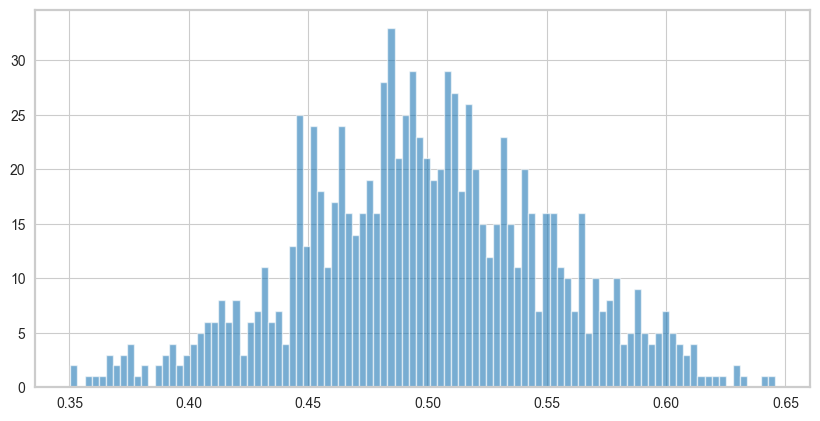

In [53]:
plt.hist(r_actions, **plt_kwargs)
plt.show()

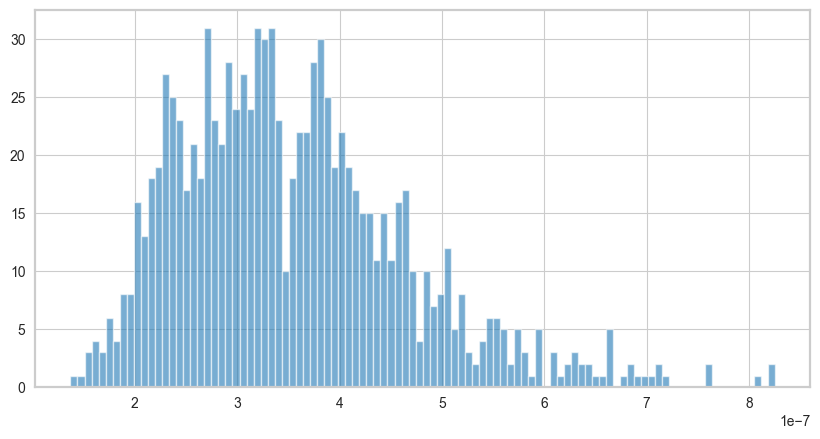

In [52]:
plt.hist(m_actions, **plt_kwargs)
plt.show()

## eval

In [30]:
rl_pnl_0 = np.load('best_results/pnl_train/rl_pnl.npy')
ntb_pnl_0 = np.load('best_results/pnl_train/ntb_pnl.npy')

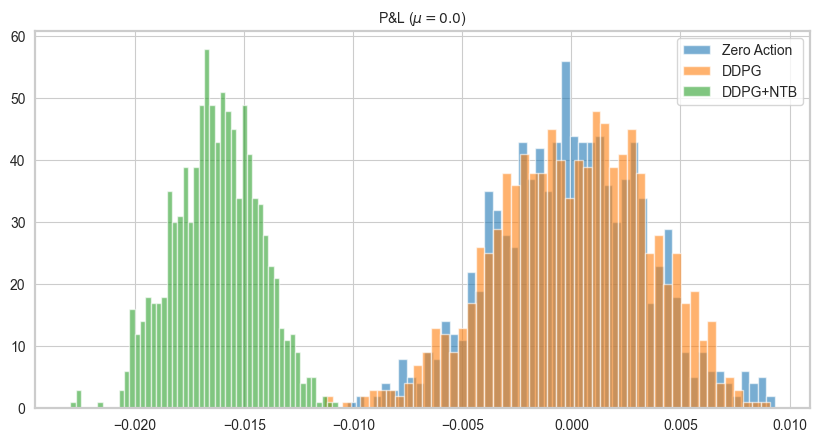

rl pnl: 		[-0.      0.0001  0.0035]
ntb pnl: 		[-0.0163 -0.0163  0.002 ]
zero pnl: 		[-0.0002 -0.0001  0.0034]

rl cvar:		0.00742
ntb cvar:		0.02030
zero cvar:		0.00729



In [38]:
plt_kwargs = {'bins':50,
              # 'range':(-0.05, 0.01),
              'alpha':0.6}

plt.title(r'P&L ($\mu=0.0$)')
plt.hist(zero_pnl, **plt_kwargs, label='Zero Action')
plt.hist(rl_pnl_0, **plt_kwargs, label='DDPG')
plt.hist(ntb_pnl_0, **plt_kwargs, label='DDPG+NTB')

plt.legend()
plt.show()

print(f'rl pnl: \t\t{np.round(pnl_reward(rl_pnl_0), 4)}')
print(f'ntb pnl: \t\t{np.round(pnl_reward(ntb_pnl_0), 4)}')
print(f'zero pnl: \t\t{np.round(pnl_reward(zero_pnl), 4)}')
# print(f'random pnl: \t{np.round(pnl_reward(random_pnl), 4)}')
# print(f'delta pnl: \t\t{np.round(pnl_reward(delta_pnl), 4)}')
print()

print(f'rl cvar:\t\t{cvar(rl_pnl_0):.5f}')
print(f'ntb cvar:\t\t{cvar(ntb_pnl_0):.5f}')
print(f'zero cvar:\t\t{cvar(zero_pnl):.5f}')
# print(f'random cvar:\t{cvar(random_pnl):.5f}')
# print(f'delta cvar:\t\t{cvar(delta_pnl):.5f}')
print()

In [42]:
rl_pnl_1 = np.load('best_results/pnl_train/rl_pnl_drift.npy')
ntb_pnl_1 = np.load('best_results/pnl_train/ntb_pnl_drift.npy')

zero_pnl = eval_env.eval(tmp, 'pnl', 100)

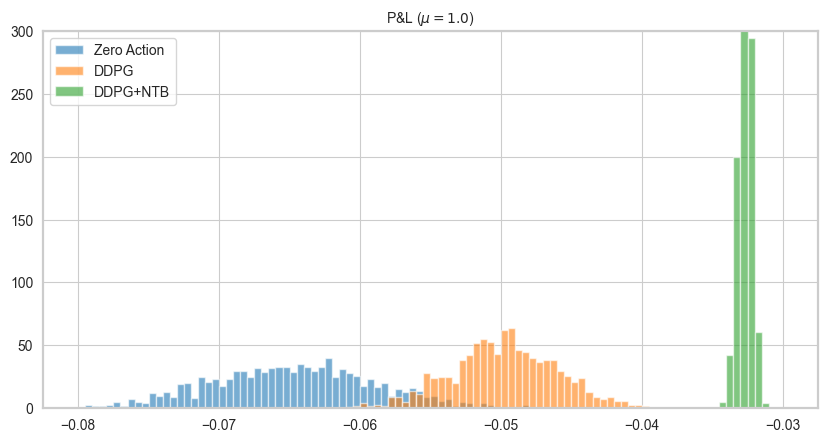

rl pnl: 		[-0.0498 -0.0497  0.0038]
ntb pnl: 		[-0.0327 -0.0327  0.0005]
zero pnl: 		[-0.065  -0.0649  0.006 ]

rl cvar:		0.05763
ntb cvar:		0.03371
zero cvar:		0.07744



In [46]:
plt_kwargs = {'bins':100,
              'range':(-0.08, -0.03),
              'alpha':0.6}

plt.title(r'P&L ($\mu=1.0$)')
plt.hist(zero_pnl, **plt_kwargs, label='Zero Action')
plt.hist(rl_pnl_1, **plt_kwargs, label='DDPG')
plt.hist(ntb_pnl_1, **plt_kwargs, label='DDPG+NTB')

plt.ylim(0, 300)
plt.legend()
plt.show()

print(f'rl pnl: \t\t{np.round(pnl_reward(rl_pnl_1), 4)}')
print(f'ntb pnl: \t\t{np.round(pnl_reward(ntb_pnl_1), 4)}')
print(f'zero pnl: \t\t{np.round(pnl_reward(zero_pnl), 4)}')
# print(f'random pnl: \t{np.round(pnl_reward(random_pnl), 4)}')
# print(f'delta pnl: \t\t{np.round(pnl_reward(delta_pnl), 4)}')
print()

print(f'rl cvar:\t\t{cvar(rl_pnl_1):.5f}')
print(f'ntb cvar:\t\t{cvar(ntb_pnl_1):.5f}')
print(f'zero cvar:\t\t{cvar(zero_pnl):.5f}')
# print(f'random cvar:\t{cvar(random_pnl):.5f}')
# print(f'delta cvar:\t\t{cvar(delta_pnl):.5f}')
print()

In [1]:
from Env.env import BSMarket
from Utils.prices import european_call_delta

env = BSMarket(1000, 0.02, drift=1.0, )

env 'BSMarket was created!


In [13]:
def eval_pnl(env, model=None, reward_mode='pnl', n=1):
    tmp = env.reward_mode
    env.reward_mode = reward_mode

    result = []
    for _ in range(n):
        obs = env.reset()
        reward, done, info = 0, False, {}
        total_raw_reward = 0
        while not done:
            moneyness, expiry, volatility = [obs[..., i] for i in range(3)]
            action = european_call_delta(moneyness, expiry, volatility)
            obs, reward, done, info = env.step(action)
            total_raw_reward += info['raw_reward']
        result.append(total_raw_reward)

    env.reward_mode = tmp

    return np.mean(result, axis=0)

def eval_pnl2(env, model=None, reward_mode='pnl', n=1):
    tmp = env.reward_mode
    env.reward_mode = reward_mode

    result = []
    for _ in range(n):
        obs = env.reset()
        reward, done, info = 0, False, {}
        total_raw_reward = 0
        i = 0
        while not done:
            moneyness, expiry, volatility = [obs[..., i] for i in range(3)]
            # action = env.delta[i]
            obs, reward, done, info = env.step(action)
            total_raw_reward += info['raw_reward']
            i+= 1
        result.append(total_raw_reward)

    env.reward_mode = tmp

    return np.mean(result, axis=0)

In [14]:
from Utils.tensors import set_seed

set_seed()
delta1 = eval_pnl(env, n=100)
set_seed()
delta2 = eval_pnl2(env, n=100)

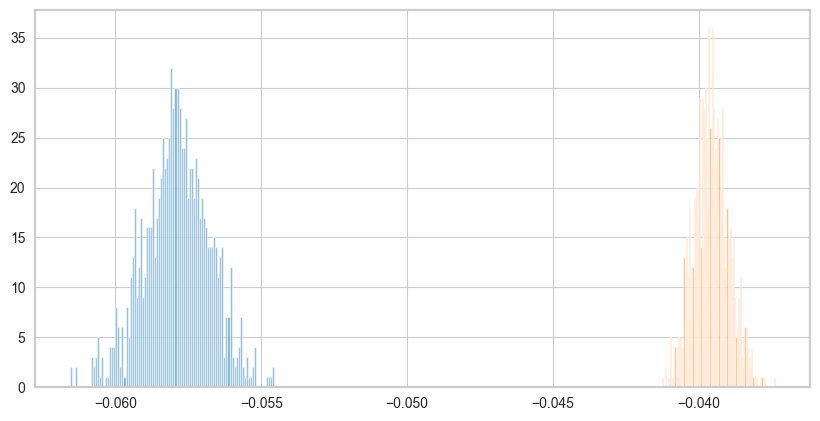

In [15]:
plt_kwargs = {'bins': 100,
              'alpha': 0.6}

plt.hist(delta1, **plt_kwargs)
plt.hist(delta2, **plt_kwargs)
plt.show()